<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/enhancing_rag_with_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --upgrade --quiet  langchain langchain-community langchain-openai langchain-experimental neo4j wikipedia tiktoken yfiles_jupyter_graphs

In [ ]:
from langchain_core.runnables import (
    RunnableBranch,
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Tuple, List, Optional
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
import os
from langchain_community.graphs import Neo4jGraph
from langchain.document_loaders import WikipediaLoader
from langchain.text_splitter import TokenTextSplitter
from langchain_openai import ChatOpenAI
from langchain_experimental.graph_transformers import LLMGraphTransformer
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars
from langchain_core.runnables import ConfigurableField, RunnableParallel, RunnablePassthrough

try:
  import google.colab
  from google.colab import output
  output.enable_custom_widget_manager()
except:
  pass

# Enhancing RAG-based applications accuracy by constructing and leveraging knowledge graphs
## A practical guide to constructing and retrieving information from knowledge graphs in RAG applications with Neo4j and LangChain

Graph retrieval augmented generation (Graph RAG) is gaining momentum and emerging as a powerful addition to traditional vector search retrieval methods. This approach leverages the structured nature of graph databases, which organize data as nodes and relationships, to enhance the depth and contextuality of retrieved information.

Graphs are great at representing and storing heterogeneous and interconnected information in a structured manner, effortlessly capturing complex relationships and attributes across diverse data types. In contrast, vector databases often struggle with such structured information, as their strength lies in handling unstructured data through high-dimensional vectors. In your RAG application, you can combine structured graph data with vector search through unstructured text to achieve the best of both worlds, which is exactly what we will do in this blog post.

Knowledge graphs are great, but how do you create one? Constructing a knowledge graph is typically the most challenging step in leveraging the power of graph-based data representation. It involves gathering and structuring the data, which requires a deep understanding of both the domain and graph modeling. To simplify this process, we have been experimenting with LLMs. LLMs, with their profound understanding of language and context, can automate significant parts of the knowledge graph creation process. By analyzing text data, these models can identify entities, understand the relationships between them, and suggest how they might be best represented in a graph structure. As a result of these experiments, we have added the first version of the graph construction module to LangChain, which we will demonstrate in this blog post.

## Neo4j Environment Setup

You need to set up a Neo4j instance follow along with the examples in this blog post. The easiest way is to start a free instance on [Neo4j Aura](https://neo4j.com/cloud/platform/aura-graph-database/), which offers cloud instances of Neo4j database. Alternatively, you can also set up a local instance of the Neo4j database by downloading the Neo4j Desktop application and creating a local database instance.

In [ ]:
os.environ["OPENAI_API_KEY"] = "sk-"
os.environ["NEO4J_URI"] = "bolt://18.212.197.205:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "tendencies-meanings-enlistment"

graph = Neo4jGraph()

Additionally, you must provide an [OpenAI key](https://openai.com/), as we will use their models in this blog post.
## Data ingestion
For this demonstration, we will use Elizabeth I's Wikipedia page. We can utilize [LangChain loaders](https://python.langchain.com/docs/modules/data_connection/document_loaders/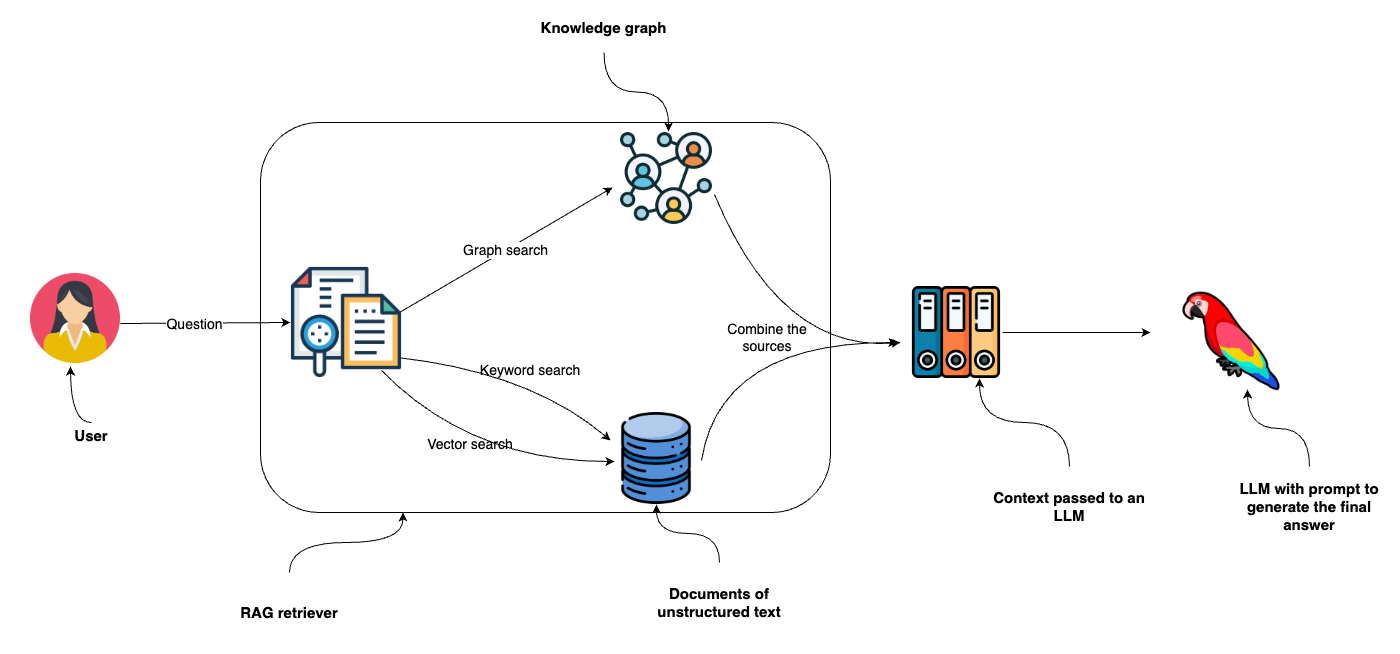) to fetch and split the documents from Wikipedia seamlessly.

In [ ]:
# Read the wikipedia article
raw_documents = WikipediaLoader(query="Elizabeth I").load()
# Define chunking strategy
text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=24)
documents = text_splitter.split_documents(raw_documents[:3])

/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Now it's time to construct a graph based on the retrieved documents. For this purpose, we have implemented an `LLMGraphTransformermodule` that significantly simplifies constructing and storing a knowledge graph in a graph database.

In [ ]:
llm=ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-0125") # gpt-4-0125-preview occasionally has issues
llm_transformer = LLMGraphTransformer(llm=llm)

graph_documents = llm_transformer.convert_to_graph_documents(documents)
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

You can define which LLM you want the knowledge graph generation chain to use. At the moment, we support only function calling models from OpenAI and Mistral. However, we plan to expand the LLM selection in the future. In this example, we are using the latest GPT-4. Note that the quality of generated graph significantly depends on the model you are using. In theory, you always want to use the most capable one. The LLM graph transformers returns graph documents, which can be imported to Neo4j via the `add_graph_documents` method. The `baseEntityLabel` parameter assigns an additional `__Entity__` label to each node, enhancing indexing and query performance. The `include_source` parameter links nodes to their originating documents, facilitating data traceability and context understanding.

You can inspect the generated graph with yfiles visualization.

In [ ]:
# directly show the graph resulting from the given Cypher query
default_cypher = "MATCH (s)-[r:!MENTIONS]->(t) RETURN s,r,t LIMIT 50"

def showGraph(cypher: str = default_cypher):
    # create a neo4j session to run queries
    driver = GraphDatabase.driver(
        uri = os.environ["NEO4J_URI"],
        auth = (os.environ["NEO4J_USERNAME"],
                os.environ["NEO4J_PASSWORD"]))
    session = driver.session()
    widget = GraphWidget(graph = session.run(cypher).graph())
    widget.node_label_mapping = 'id'
    #display(widget)
    return widget

showGraph()

GraphWidget(layout=Layout(height='800px', width='100%'))

## Hybrid Retrieval for RAG
After the graph generation, we will use a hybrid retrieval approach that combines vector and keyword indexes with graph retrieval for RAG applications.

![retrieval](https://raw.githubusercontent.com/tomasonjo/blogs/master/graphhybrid.png)

The diagram illustrates a retrieval process beginning with a user posing a question, which is then directed to an RAG retriever. This retriever employs keyword and vector searches to search through unstructured text data and combines it with the information it collects from the knowledge graph. Since Neo4j features both keyword and vector indexes, you can implement all three retrieval options with a single database system. The collected data from these sources is fed into an LLM to generate and deliver the final answer.
## Unstructured data retriever
You can use the Neo4jVector.from_existing_graph method to add both keyword and vector retrieval to documents. This method configures keyword and vector search indexes for a hybrid search approach, targeting nodes labeled Document. Additionally, it calculates text embedding values if they are missing.



In [ ]:
vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding"
)

The vector index can then be called with the similarity_search method.
## Graph retriever
On the other hand, configuring a graph retrieval is more involved but offers more freedom. In this example, we will use a full-text index to identify relevant nodes and then return their direct neighborhood.

![graph](https://raw.githubusercontent.com/tomasonjo/blogs/master/neighbor.png)

The graph retriever starts by identifying relevant entities in the input. For simplicity, we instruct the LLM to identify people, organizations, and locations. To achieve this, we will use LCEL with the newly added `with_structured_output` method to achieve this.

In [ ]:
# Retriever

graph.query(
    "CREATE FULLTEXT INDEX entity IF NOT EXISTS FOR (e:__Entity__) ON EACH [e.id]")

# Extract entities from text
class Entities(BaseModel):
    """Identifying information about entities."""

    names: List[str] = Field(
        ...,
        description="All the person, organization, or business entities that "
        "appear in the text",
    )

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are extracting organization and person entities from the text.",
        ),
        (
            "human",
            "Use the given format to extract information from the following "
            "input: {question}",
        ),
    ]
)

entity_chain = prompt | llm.with_structured_output(Entities)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/beta_decorator.py:86: LangChainBetaWarning: The function `with_structured_output` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


Let's test it out:

In [ ]:
entity_chain.invoke({"question": "Where was Amelia Earhart born?"}).names

['Amelia Earhart']

Great, now that we can detect entities in the question, let's use a full-text index to map them to the knowledge graph. First, we need to define a full-text index and a function that will generate full-text queries that allow a bit of misspelling, which we won't go into much detail here.

In [ ]:
def generate_full_text_query(input: str) -> str:
    """
    Generate a full-text search query for a given input string.

    This function constructs a query string suitable for a full-text search.
    It processes the input string by splitting it into words and appending a
    similarity threshold (~2 changed characters) to each word, then combines
    them using the AND operator. Useful for mapping entities from user questions
    to database values, and allows for some misspelings.
    """
    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el]
    for word in words[:-1]:
        full_text_query += f" {word}~2 AND"
    full_text_query += f" {words[-1]}~2"
    return full_text_query.strip()

# Fulltext index query
def structured_retriever(question: str) -> str:
    """
    Collects the neighborhood of entities mentioned
    in the question
    """
    result = ""
    entities = entity_chain.invoke({"question": question})
    for entity in entities.names:
        response = graph.query(
            """CALL db.index.fulltext.queryNodes('entity', $query, {limit:2})
            YIELD node,score
            CALL {
              WITH node
              MATCH (node)-[r:!MENTIONS]->(neighbor)
              RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output
              UNION ALL
              WITH node
              MATCH (node)<-[r:!MENTIONS]-(neighbor)
              RETURN neighbor.id + ' - ' + type(r) + ' -> ' +  node.id AS output
            }
            RETURN output LIMIT 50
            """,
            {"query": generate_full_text_query(entity)},
        )
        result += "\n".join([el['output'] for el in response])
    return result

The `structured_retriever` function starts by detecting entities in the user question. Next, it iterates over the detected entities and uses a Cypher template to retrieve the neighborhood of relevant nodes. Let's test it out!

In [ ]:
print(structured_retriever("Who is Elizabeth I?"))

Elizabeth I - RULED -> England
Elizabeth I - RULED -> Ireland
Elizabeth I - BELONGED_TO -> House Of Tudor
Elizabeth I - PARENT -> Henry Viii
Elizabeth I - PARENT -> Anne Boleyn
Henry Viii - SPOUSE -> Anne Boleyn
Henry Viii - PARENT -> Edward Vi
Edward Vi - BEQUEATHED_CROWN_TO -> Lady Jane Grey
Edward Vi - IGNORED_CLAIMS_OF -> Mary
Edward Vi - IGNORED_CLAIMS_OF -> Elizabeth I
Mary - IMPRISONED -> Elizabeth I
Elizabeth I - DEPENDED_ON -> William Cecil
Elizabeth I - CREATED_TITLE -> Baron Burghley
Elizabeth I - SUCCEEDED_BY -> James Vi Of Scotland
Mary, Queen Of Scots - PARENT -> James Vi Of Scotland
Elizabeth I - DEPENDED_ON -> Francis Walsingham
Elizabeth - WAR -> Spain
Elizabeth - WAR -> Netherlands
Elizabeth - WAR -> France
Elizabeth - WAR -> Ireland
Elizabeth - LEAD -> William Shakespeare
Elizabeth - LEAD -> Christopher Marlowe
Elizabeth - LEAD -> Francis Drake
Elizabeth - LEAD -> Walter Raleigh
Elizabeth - DEFEAT -> Spanish Armada
Elizabeth I - SUCCESSOR -> James Vi Of Scotland
Henr

## Final retriever
As we mentioned at the start, we'll combine the unstructured and graph retriever to create the final context that will be passed to an LLM.

In [ ]:
def retriever(question: str):
    print(f"Search query: {question}")
    structured_data = structured_retriever(question)
    unstructured_data = [el.page_content for el in vector_index.similarity_search(question)]
    final_data = f"""Structured data:
{structured_data}
Unstructured data:
{"#Document ". join(unstructured_data)}
    """
    return final_data

As we are dealing with Python, we can simply concatenate the outputs using the f-string.
## Defining the RAG chain
We have successfully implemented the retrieval component of the RAG. First, we will introduce the query rewriting part that allows conversational follow up questions.


In [ ]:
# Condense a chat history and follow-up question into a standalone question
_template = """Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question,
in its original language.
Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:"""  # noqa: E501
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

def _format_chat_history(chat_history: List[Tuple[str, str]]) -> List:
    buffer = []
    for human, ai in chat_history:
        buffer.append(HumanMessage(content=human))
        buffer.append(AIMessage(content=ai))
    return buffer

_search_query = RunnableBranch(
    # If input includes chat_history, we condense it with the follow-up question
    (
        RunnableLambda(lambda x: bool(x.get("chat_history"))).with_config(
            run_name="HasChatHistoryCheck"
        ),  # Condense follow-up question and chat into a standalone_question
        RunnablePassthrough.assign(
            chat_history=lambda x: _format_chat_history(x["chat_history"])
        )
        | CONDENSE_QUESTION_PROMPT
        | ChatOpenAI(temperature=0)
        | StrOutputParser(),
    ),
    # Else, we have no chat history, so just pass through the question
    RunnableLambda(lambda x : x["question"]),
)

Next, we introduce a prompt that leverages the context provided by the integrated hybrid retriever to produce the response, completing the implementation of the RAG chain.

In [ ]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
Use natural language and be concise.
Answer:"""
prompt = ChatPromptTemplate.from_template(template)

chain = (
    RunnableParallel(
        {
            "context": _search_query | retriever,
            "question": RunnablePassthrough(),
        }
    )
    | prompt
    | llm
    | StrOutputParser()
)

Finally, we can go ahead and test our hybrid RAG implementation.

In [ ]:
chain.invoke({"question": "Which house did Elizabeth I belong to?"})

Search query: Which house did Elizabeth I belong to?


'Elizabeth I belonged to the House of Tudor.'

Let's test a follow up question!

In [ ]:
chain.invoke(
    {
        "question": "When was she born?",
        "chat_history": [("Which house did Elizabeth I belong to?", "House Of Tudor")],
    }
)

Search query: When was Elizabeth I born?


'Elizabeth I was born on 7 September 1533.'